In [1]:
# === Core scientific libraries ===
import numpy as np
import pandas as pd

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Scipy (scientific functions) ===
from scipy import stats
from scipy.stats import norm, expon
from scipy.special import expit

# === Statsmodels (econometrics / statistical modeling) ===
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.api import OLS

# === Scikit-learn: preprocessing ===
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# === Scikit-learn: models (supervised learning) ===
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

# === Scikit-learn: model selection & evaluation ===
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
from sklearn.utils import resample

# === Causal inference (DoubleML) ===
import doubleml as dml
from doubleml import DoubleMLData, DoubleMLPLR, DoubleMLIRM

# === Other machine learning libraries ===
import GPy

# === Parallelization ===
from joblib import Parallel, delayed

# === Utilities ===
import itertools
import pickle
import os
import warnings

In [2]:
# Assigning the current directory to this_dir
from pathlib import Path
this_dir = Path (".")

# make it absolute
print(this_dir.resolve())

C:\Users\Anna\master_thesis\master_thesis


## Data Creation

Now I will collect data files, correct them with the list of selected countries* and make long format to make it more convenient for Machine Learning.

*These countries mostly have no NA values in all datasets.   
Nevertheless, there were some correction for Ireland:

In dataset related to municipal waste per capita:
- The average was taken for 2015
- Total municipal wastes for 2 last years were taken from here https://www.cso.ie/en/releasesandpublications/ep/p-eii/environmentalindicatorsireland2023/waste/#:~:text=Municipal%20waste%20generated%20in%20Ireland%20was%203.2%20million%20tonnes%20in,kilogrammes%20per%20capita%20in%202021 and waste per capita was calculated depending on Ireland population.

For Serbia data for environment tax revenue as % of GDP was taken from https://data.stat.gov.rs/Home/Result/2503030203?languageCode=en-US.


In [3]:
selected_countries = ["Czechia", "Ireland", "Cyprus", "Hungary", "Serbia", 
                       "Sweden", "France", "Spain", "Netherlands", "Germany", "Italy",
                       "Poland", "Lithuania", "Portugal", "Latvia", "Malta", 
                       "Slovenia", "Estonia", "Croatia", "Greece", "Bulgaria", "Slovakia", "Switzerland", "Romania"]

### Policy

In [4]:
data_file_p = this_dir / "data" / "policy_upd.xlsx"
data_file_p.resolve()
df_policy = pd.read_excel(data_file_p, sheet_name="Sheet1")

from help_func import convert_to_long_format
# Converting into long format
df_policy_long = convert_to_long_format(df_policy, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='Policy')

print(df_policy_long)

         Country  Year  Policy
0        Belgium  2014       0
1        Czechia  2014       0
2        Denmark  2014       0
3        Germany  2014       0
4        Estonia  2014       0
..           ...   ...     ...
265  Switzerland  2022       0
266       Serbia  2022       1
267     Bulgaria  2022       0
268     Slovakia  2022       0
269      Romania  2022       0

[270 rows x 3 columns]


In [5]:
data_dir = this_dir / "data"
obtained_data_dir = data_dir / "obtained_data"

latex_table_p = df_policy.to_latex(index=False)

# Direction to file where will be stored Latex-table
latex_output_file = obtained_data_dir / "policy_table.tex"

with open(latex_output_file, "w", encoding="utf-8") as f:
    f.write(latex_table_p)

### Municipal Wastes

Afterwards, I will move on to the data on municipal waste, which is measured in kilograms per capita.
Municipal waste refers to waste generated by households, as well as small businesses and institutions, that is collected by or on behalf of municipalities. It typically includes waste from residential areas, street cleaning, and similar sources.

*All used datasets below are taken form official web-site of Euro Union statistics: https://ec.europa.eu/eurostat/databrowser/explore/all/all_themes

In [6]:
data_file_w = this_dir / "data" / "env_waste_mun.xlsx"
data_file_w.resolve()
data_was = pd.read_excel(data_file_w, sheet_name="Sheet 1", na_values=':')
data_was = data_was.rename(columns={"TIME": "Country"})

In [7]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')

filtered_data_was = data_was[data_was["Country"].isin(selected_countries)]

from help_func import convert_to_long_format

filtered_data_was_long = convert_to_long_format(filtered_data_was, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='waste_per_cap')

print(filtered_data_was_long)

         Country  Year  waste_per_cap
0       Bulgaria  2013          438.0
1        Czechia  2013          307.0
2        Germany  2013          615.0
3        Estonia  2013          293.0
4        Ireland  2013            NaN
..           ...   ...            ...
235     Slovenia  2022          487.0
236     Slovakia  2022          478.0
237       Sweden  2022          395.0
238  Switzerland  2022          677.0
239       Serbia  2022          473.0

[240 rows x 3 columns]


In [8]:
# Find rows where the country is Denmark.
is_denmark = filtered_data_was_long['Country'] == 'Denmark'

# Decrease the waste_per_cap values for Denmark by 10%.
filtered_data_was_long.loc[is_denmark, 'waste_per_cap'] *= 0.9
filtered_data_was_long

,Country,Year,waste_per_cap
0,Bulgaria,2013,438.0
1,Czechia,2013,307.0
2,Germany,2013,615.0
3,Estonia,2013,293.0
4,Ireland,2013,NaN
...,...,...,...
235,Slovenia,2022,487.0
236,Slovakia,2022,478.0
237,Sweden,2022,395.0
238,Switzerland,2022,677.0


 C:\Users\Anna\AppData\Local\Temp\ipykernel_2496\1444614643.py:7: UserWarning:Ignoring `palette` because no `hue` variable has been assigned.


<Figure size 1000x600 with 0 Axes>

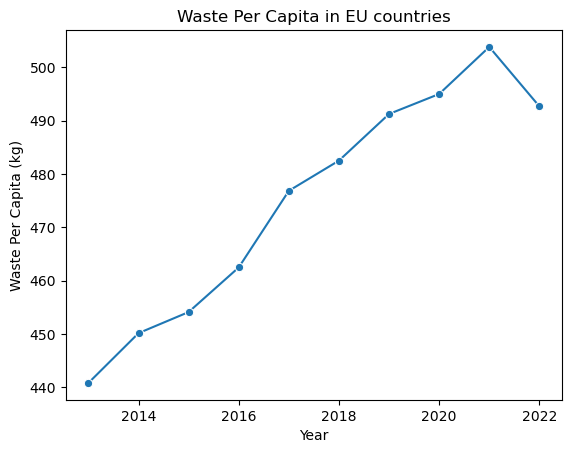

In [9]:
# Аggregation
avg_trends_waste = filtered_data_was_long.groupby(['Year'])['waste_per_cap'].mean().reset_index()

# Waste Per Capita
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
sns.lineplot(data=avg_trends_waste, x='Year', y='waste_per_cap', 
             palette=["blue"], marker="o")

plt.title('Waste Per Capita in EU countries')
plt.ylabel('Waste Per Capita (kg)')
plt.xlabel('Year')
plt.show()

I will analyze this variable in more detail, so we need data for all years from 2013 to 2022 (later, due to the limitations of some datasets, data from 2015 to 2022 will be used). I will start with analysis unexpected outliers in waste growth for any given year.

<Axes: xlabel='Year'>

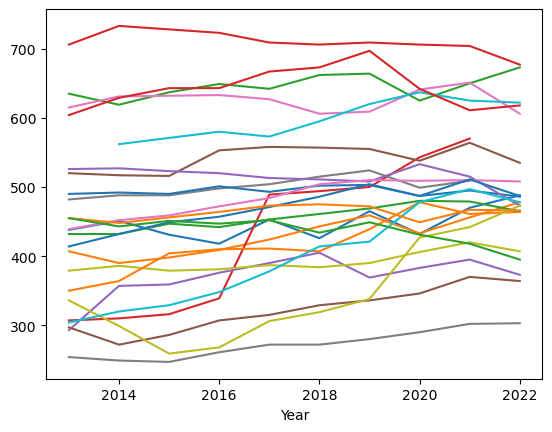

In [10]:
filtered_data_was_long.pivot(columns=['Country'], index='Year').plot(legend=False)

### Covariates

Let's gather data for the covariates   

#### Environmental Taxes

In [11]:
data_file_t = this_dir / "data" / "env_tax_gdp_per.xlsx"
data_file_t.resolve()
data_etax = pd.read_excel(data_file_t, sheet_name="Sheet 1")
data_etax = data_etax.rename(columns={"TIME": "Country"})

filtered_data_etax = data_etax[data_etax["Country"].isin(selected_countries)]

In [12]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_etax_long = convert_to_long_format(filtered_data_etax, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='env_tax')
print(filtered_data_etax_long)

         Country  Year env_tax
0       Bulgaria  2014    2.84
1        Czechia  2014    2.12
2        Germany  2014    1.99
3        Estonia  2014    2.66
4        Ireland  2014     2.4
..           ...   ...     ...
211     Slovenia  2022    2.87
212     Slovakia  2022    2.47
213       Sweden  2022    1.91
214  Switzerland  2022    1.27
215       Serbia  2022     3.4

[216 rows x 3 columns]


#### Unemployment

In [13]:
data_file_u = this_dir / "data" / "unemp_percent.xlsx"
data_file_u.resolve()
data_unemp = pd.read_excel(data_file_u, sheet_name="Sheet 1")
data_unemp = data_unemp.rename(columns={"TIME": "Country"})

filtered_data_unemp = data_unemp[data_unemp["Country"].isin(selected_countries)]
filtered_data_unemp = filtered_data_unemp.drop(filtered_data_unemp.columns[1:2], axis=1)
filtered_data_unemp = filtered_data_unemp.drop(filtered_data_unemp.columns[-1], axis=1)


In [14]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_unemp_long = convert_to_long_format(filtered_data_unemp, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='unemp_rate')


print(filtered_data_unemp_long)

         Country  Year unemp_rate
0       Bulgaria  2015       10.1
1        Czechia  2015        5.1
2        Germany  2015        4.4
3        Estonia  2015        6.4
4        Ireland  2015        9.9
..           ...   ...        ...
187     Slovenia  2022          4
188     Slovakia  2022        6.1
189       Sweden  2022        7.5
190  Switzerland  2022        4.1
191       Serbia  2022        9.6

[192 rows x 3 columns]


#### Real Expenditures

In [15]:
data_file_e = this_dir / "data" / "real_exp_pc.xlsx"
data_file_e.resolve()
data_exp = pd.read_excel(data_file_e, sheet_name="Sheet 1")
data_exp = data_exp.rename(columns={"TIME": "Country"})

filtered_data_exp = data_exp[data_exp["Country"].isin(selected_countries)]
filtered_data_exp = filtered_data_exp.drop(filtered_data_exp.columns[-1], axis=1)


In [16]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_exp_long = convert_to_long_format(filtered_data_exp, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='rexp_per_cap')

print(filtered_data_exp_long)

         Country  Year rexp_per_cap
0       Bulgaria  2014         9600
1        Czechia  2014        14500
2        Germany  2014        22500
3        Estonia  2014        12700
4        Ireland  2014        17300
..           ...   ...          ...
211     Slovenia  2022        20200
212     Slovakia  2022        17900
213       Sweden  2022        26000
214  Switzerland  2022        27300
215       Serbia  2022        12300

[216 rows x 3 columns]


#### Urbanization

In [17]:
data_file_ur = this_dir / "data" / "p_urbanization.xlsx"
data_file_ur.resolve()
data_urb = pd.read_excel(data_file_ur, sheet_name="Data")
data_urb = data_urb.rename(columns={"TIME": "Country"})

filtered_data_urb = data_urb[data_urb["Country"].isin(selected_countries)]


In [18]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_urb_long = convert_to_long_format(filtered_data_urb, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='urb_ind')

print(filtered_data_urb_long)

         Country  Year  urb_ind
0        Germany  2014   77.190
1        Estonia  2014   68.269
2         Sweden  2014   86.247
3          Spain  2014   79.366
4         France  2014   79.394
..           ...   ...      ...
211  Switzerland  2022   74.092
212       Greece  2022   80.357
213     Bulgaria  2022   76.363
214     Slovakia  2022   53.909
215      Romania  2022   54.489

[216 rows x 3 columns]


### Merging

In [19]:
# Merging tables on the columns 'Country' and 'Year'
df_combined1 = pd.merge(filtered_data_was_long, df_policy_long,
                       on=['Country', 'Year'], how='inner')

# Adding other covariates in a similar way
df_combined2 = pd.merge(df_combined1, filtered_data_etax_long, on=['Country', 'Year'], how='inner')
df_combined3 = pd.merge(df_combined2, filtered_data_unemp_long, on=['Country', 'Year'], how='inner')
df_combined4 = pd.merge(df_combined3, filtered_data_exp_long, on=['Country', 'Year'], how='inner')
df = pd.merge(df_combined4, filtered_data_urb_long, on=['Country', 'Year'], how='inner')

df['waste_per_cap'] = pd.to_numeric(df['waste_per_cap'], errors='coerce')

print(df)

         Country  Year  waste_per_cap  Policy env_tax unemp_rate rexp_per_cap  \
0       Bulgaria  2015          431.0       0    2.95       10.1        10000   
1        Czechia  2015          316.0       0    2.05        5.1        14800   
2        Germany  2015          632.0       0    1.92        4.4        22800   
3        Estonia  2015          359.0       0    2.73        6.4        13300   
4        Ireland  2015          571.0       0    1.89        9.9        17800   
..           ...   ...            ...     ...     ...        ...          ...   
187     Slovenia  2022          487.0       1    2.87          4        20200   
188     Slovakia  2022          478.0       0    2.47        6.1        17900   
189       Sweden  2022          395.0       1    1.91        7.5        26000   
190  Switzerland  2022          677.0       0    1.27        4.1        27300   
191       Serbia  2022          473.0       1     3.4        9.6        12300   

     urb_ind  
0     73.990

In [20]:
# Create feature 'Group': 1 if a country has ever adopted 'Policy' , 0 - never adopted 'Policy' 
new_cols = list(df.columns)
new_cols.insert(4, 'Group')
policy_per_country = df.groupby('Country')['Policy'].max()
df['Group'] = df['Country'].map(policy_per_country)
df = df[new_cols]

In [21]:
# Preview example of df
df[df.Country.isin(['Croatia'])]

,Country,Year,waste_per_cap,Policy,Group,env_tax,unemp_rate,rexp_per_cap,urb_ind
8,Croatia,2015,398.0,0,1,4.21,16.2,11600,56.155
32,Croatia,2016,409.0,0,1,4.31,13,12100,56.403
56,Croatia,2017,424.0,0,1,4.33,11.1,12700,56.667
80,Croatia,2018,443.0,1,1,4.36,8.3,13300,56.947
104,Croatia,2019,459.0,1,1,4.24,6.6,13900,57.242
128,Croatia,2020,433.0,1,1,4.07,7.4,13600,57.553
152,Croatia,2021,456.0,1,1,3.86,7.5,15500,57.878
176,Croatia,2022,478.0,1,1,3.34,6.8,17600,58.219


In [22]:
data_dir = this_dir / "data"
obtained_data_dir = data_dir / "obtained_data"
output_file = obtained_data_dir / "original_data.xlsx"
df.to_excel(output_file, index=False)

In [23]:
df_preview = pd.concat([df.head(5), df.tail(5)])

latex_table_all = df_preview.to_latex(index=False)

latex_output_file_1 = obtained_data_dir / "f_table.tex"

with open(latex_output_file_1, "w", encoding="utf-8") as f:
    f.write(latex_table_all)

## Data Analysis and Preprocessing

Let's visualize the general trend of the waste level for each country group: plot mean waste of those countries who adopted the Policy versus those who did not.

<Figure size 1000x600 with 0 Axes>

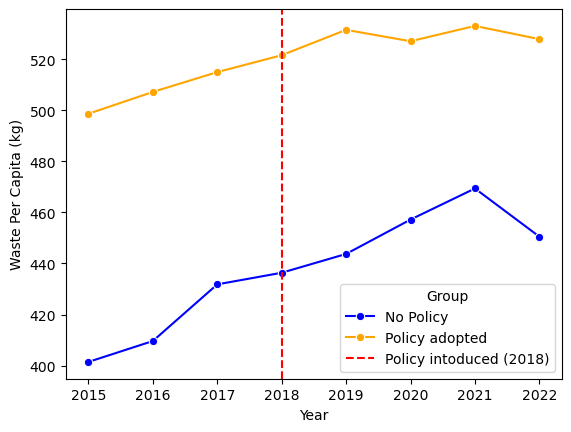

In [24]:
# Аggregation
avg_trends_waste = df.groupby(['Year', 'Group'])['waste_per_cap'].mean().reset_index()

# Waste Per Capita
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
sns.lineplot(data=avg_trends_waste, x='Year', y='waste_per_cap', hue='Group', 
             palette=["blue", "orange"], marker="o")

plt.axvline(2018, color='red', linestyle='--', label='Policy intoduced (2018)')
#plt.title('Waste Per Capita Trends by Group (With and Without Policy)')
plt.ylabel('Waste Per Capita (kg)')
plt.xlabel('Year')
handles, labels = ax.get_legend_handles_labels()
labels[0] = 'No Policy'
labels[1] = 'Policy adopted'
plt.legend(title='Group', handles=handles, labels=labels)
plt.show()

As before I am assuming that each country's decision is based on their general migration policy which is stay the same from the begininng. 
I will consider problem related to finding ATE of having such type of Policy during several years.

*NB. The adoption of the policy does not lead to an impact, as these changes will not show the effect within our short observation period. The fact that the policy exists classifies a country into a certain group.*

Also, despite having years, we are not considering time dependency and do not use years as a factor/time variable. We do not consider the change of waste generation (we look at the absolute value), and we do not care how the amount of waste has changed compared to the previous year; each value does not depend on the previous one (which is the definition of time dependency), meaning the process is stationary. 

*NB. Year as a factor does not have impact which was checked for the interest later.*

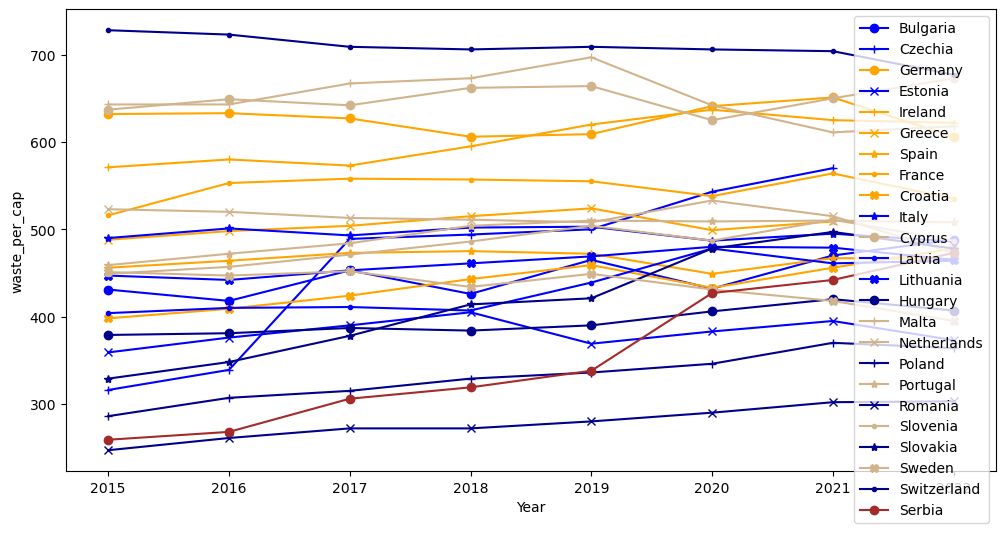

In [25]:
# Graph of waste per year for each country

countries = df["Country"].unique()
plt.figure(figsize=(12, 6))

policy_colors_markers = itertools.cycle(itertools.product(('orange', 'tan', 'brown'), ('o', '+', 'x', '*', '.', 'X')))
no_policy_colors_markers = itertools.cycle(itertools.product(('blue', 'darkblue', 'cornflowerblue'), ('o', '+', 'x', '*', '.', 'X')))

y = 'waste_per_cap'
x = 'Year'
for country in countries:
    subset = df[df["Country"] == country]
    #color = "orange" if subset["Group"].iloc[0] == 1 else "blue" 
    if  subset["Group"].iloc[0] == 1:
        color, marker = next(policy_colors_markers)
    else:
        color, marker = next(no_policy_colors_markers)
    plt.plot(subset[x], subset[y], marker=marker, label=country, color=color)

plt.xlabel(x)
plt.ylabel(y)
plt.legend()
plt.show()


Box plots of waste per capita by group:


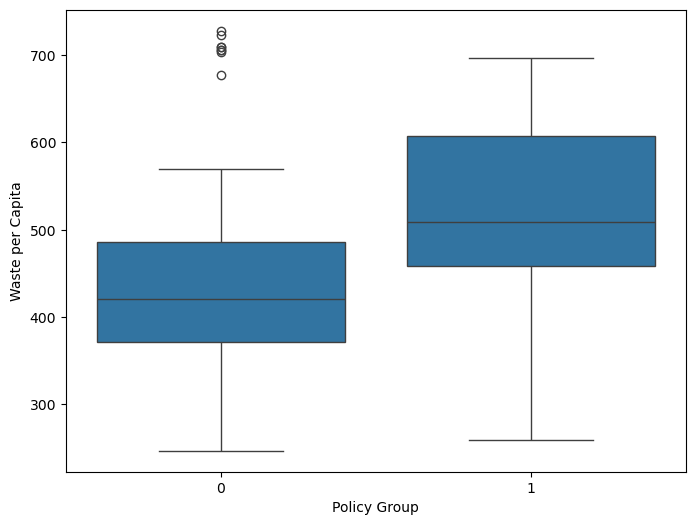

In [26]:
# Box Plots
print("\nBox plots of waste per capita by group:")
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='waste_per_cap', data=df)
#plt.title('Waste per Capita by Group (1=Policy, 0=No Policy)')
plt.xlabel('Policy Group')
plt.ylabel('Waste per Capita')
plt.show()

Before jumping in ML and DML parts it is needed to apply scaling (I chose MinMax Scaler): 

### MinMax Scaler Formula:

The MinMax Scaler is used to normalize or scale data within a specific range (between 0 and 1). The formula for MinMax scaling is:

$$ 
X_{scaled} = \frac{X - X_{min}}{X_{max} - X_{min}}
$$

In [27]:
df_n = df.copy() 

# Columns to be standardized
columns_to_scale = ['env_tax', 'unemp_rate', 'rexp_per_cap', 'urb_ind']

other_columns = ['Country', 'Year', 'waste_per_cap', 'Policy', 'Group']

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_n[columns_to_scale])

to_scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale, index=df_n.index)

# Combine standardized and non-standardized columns
scaled_df = pd.concat([df_n[other_columns], to_scaled_df], axis=1)
scaled_df['waste_per_cap'] = pd.to_numeric(scaled_df['waste_per_cap'], errors='coerce')

scaled_df = scaled_df.dropna()
scaled_df 


,Country,Year,waste_per_cap,Policy,Group,env_tax,unemp_rate,rexp_per_cap,urb_ind
0,Bulgaria,2015,431.0,0,0,0.439746,0.352174,0.059459,0.492454
1,Czechia,2015,316.0,0,0,0.249471,0.134783,0.318919,0.479987
2,Germany,2015,632.0,0,1,0.221987,0.104348,0.751351,0.570463
3,Estonia,2015,359.0,0,0,0.393235,0.191304,0.237838,0.356995
4,Ireland,2015,571.0,0,1,0.215645,0.343478,0.481081,0.214149
...,...,...,...,...,...,...,...,...,...
187,Slovenia,2022,487.0,1,1,0.422833,0.086957,0.610811,0.049211
188,Slovakia,2022,478.0,0,0,0.338266,0.178261,0.486486,0.004447
189,Sweden,2022,395.0,1,1,0.219873,0.239130,0.924324,0.844881
190,Switzerland,2022,677.0,0,0,0.084567,0.091304,0.994595,0.494933


In [28]:
data_dir = this_dir / "data"
obtained_data_dir = data_dir / "obtained_data"
output_file = obtained_data_dir / "original_data_policy_scaled.xlsx"
scaled_df.to_excel(output_file, index=False)

In [29]:
def analyze_parameters(scaled_df):
    """
    Analyzes parameters to determine their suitability for predicting
    'waste_per_cap' based on correlation and linear regression.
    
    Args:
        scaled_df (pd.DataFrame): The DataFrame containing the scaled data.
    """
    df = scaled_df
    
    columns = ['Group', 'waste_per_cap', 'env_tax', 'unemp_rate', 'rexp_per_cap', 'urb_ind']

    df = df[columns]
    y = df['waste_per_cap']

    # Analyze each covariate
    for covariate in columns[2:]:
        x = df[covariate]
        
        # 1. Correlation coefficient
        correlation = np.corrcoef(x, y)[0, 1]
        print(f"\nAnalyzing parameter: '{covariate}'")
        print(f"  - Pearson Correlation with 'waste_per_cap': {correlation:.4f}")

        # 2. Fit a simple linear regression model
        model = LinearRegression()
        try:
            model.fit(x.values.reshape(-1, 1), y)
            r_squared = model.score(x.values.reshape(-1, 1), y)
            print(f"  - R-squared value from Linear Regression: {r_squared:.4f}")
            print(f"  - Model coefficients: slope={model.coef_[0]:.4f}, intercept={model.intercept_:.4f}")
        except Exception as e:
            print(f"  - Could not fit a linear model: {e}")

In [30]:
analyze_parameters(scaled_df)


Analyzing parameter: 'env_tax'
  - Pearson Correlation with 'waste_per_cap': -0.3321
  - R-squared value from Linear Regression: 0.1103
  - Model coefficients: slope=-209.0044, intercept=558.5808

Analyzing parameter: 'unemp_rate'
  - Pearson Correlation with 'waste_per_cap': -0.1468
  - R-squared value from Linear Regression: 0.0215
  - Model coefficients: slope=-86.4198, intercept=503.9447

Analyzing parameter: 'rexp_per_cap'
  - Pearson Correlation with 'waste_per_cap': 0.6187
  - R-squared value from Linear Regression: 0.3828
  - Model coefficients: slope=297.9807, intercept=342.7678

Analyzing parameter: 'urb_ind'
  - Pearson Correlation with 'waste_per_cap': 0.4496
  - R-squared value from Linear Regression: 0.2021
  - Model coefficients: slope=177.6239, intercept=409.9099


## ML Workflow

I will start with standard OLS regressions to first investigate whether a country's group affiliation affects waste generation overall. Then, I will analyze the impact of each covariate on waste per capita by running separate regressions for each group.

In [31]:
# Does Group influence waste?

ml_df = scaled_df

y = ml_df['waste_per_cap'] 
X_new = ml_df[['Group']]
X_new = sm.add_constant(X_new)
ols_model = sm.OLS(y, X_new).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          waste_per_cap   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     31.23
Date:                Mon, 22 Sep 2025   Prob (F-statistic):           7.96e-08
Time:                        11:46:06   Log-Likelihood:                -1146.8
No. Observations:                 190   AIC:                             2298.
Df Residuals:                     188   BIC:                             2304.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        437.3563     10.904     40.110      0.0

- The coefficient for Group = 82.76 means that belonging to Group 1 (Group = 1) increases municipal waste per capita by an average of 82.76 units compared to Group 0 (if Group = 0, the average waste level is 437.36).
- A p-value of 0.000 means that the probability of obtaining such a result by chance is almost 0. Using a significance level of α = 0.05 (5%), we reject the null hypothesis that Group has no effect on waste per capita.
- Since 0 is not included in this interval, the effect of Group is statistically significant.

In [32]:
# What parameters explain waste for countries without Policy
y = ml_df['waste_per_cap'] [ml_df.Group == 0]
X_new = ml_df[["unemp_rate" , 'env_tax', 'rexp_per_cap', 'urb_ind']] [ml_df.Group == 0]

# Add const
X_new = sm.add_constant(X_new)

# (OLS)
ols_model = sm.OLS(y, X_new).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          waste_per_cap   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     53.44
Date:                Mon, 22 Sep 2025   Prob (F-statistic):           4.41e-22
Time:                        11:46:06   Log-Likelihood:                -477.21
No. Observations:                  87   AIC:                             964.4
Df Residuals:                      82   BIC:                             976.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          229.5568     30.397      7.552   

In [33]:
# What parameters explain waste for countries with Policy
y = ml_df['waste_per_cap'] [ml_df.Group == 1]
X_new = ml_df[["unemp_rate" , 'env_tax', 'rexp_per_cap', 'urb_ind']] [ml_df.Group == 1]

# Add const
X_new = sm.add_constant(X_new)

# (OLS)
ols_model = sm.OLS(y, X_new).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          waste_per_cap   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     13.58
Date:                Mon, 22 Sep 2025   Prob (F-statistic):           7.60e-09
Time:                        11:46:06   Log-Likelihood:                -589.47
No. Observations:                 103   AIC:                             1189.
Df Residuals:                      98   BIC:                             1202.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          591.7518     44.335     13.347   

In [34]:

# Model for Group 0
y0 = ml_df['waste_per_cap'][ml_df.Group == 0]
X0 = ml_df[["unemp_rate", 'env_tax', 'rexp_per_cap', 'urb_ind']][ml_df.Group == 0]
X0 = sm.add_constant(X0)
ols_model_0 = sm.OLS(y0, X0).fit()

# Model for Group 1
y1 = ml_df['waste_per_cap'][ml_df.Group == 1]
X1 = ml_df[["unemp_rate", 'env_tax', 'rexp_per_cap', 'urb_ind']][ml_df.Group == 1]
X1 = sm.add_constant(X1)
ols_model_1 = sm.OLS(y1, X1).fit()

# Predict potential outcomes for ALL observations
X_all = ml_df[["unemp_rate", 'env_tax', 'rexp_per_cap', 'urb_ind']]
X_all = sm.add_constant(X_all)

# Outcome if everyone was in Group 1
y_pred_1 = ols_model_1.predict(X_all)

# Outcome if everyone was in Group 0
y_pred_0 = ols_model_0.predict(X_all)

# Individual Treatment Effect (ITE)
ite = y_pred_1 - y_pred_0

# Average Treatment Effect (ATE)
ate_or = np.mean(ite)

print(f"The ATE calculated using the Outcome Regression (OR) method is: {ate_or:.3f}")

The ATE calculated using the Outcome Regression (OR) method is: 43.412


## Propensity Score

The new dataset b_df was introduced just for calculating propensity scores to use it later in MATHLAB for Bayesian workflow.

In [35]:
b_df = ml_df.copy()

D = b_df['Group'].values

X = b_df.drop(columns=['Country', 'Year', 'waste_per_cap', 'Policy', 'Group'])

# Estimation propensity scores via LASSO logistic regression
model = LogisticRegressionCV(
    cv=10,
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    scoring='neg_log_loss'
)
model.fit(X, D)
# Predicted probabilities
ps_est = model.predict_proba(X)[:, 1]
# The intercept and coefficients
ps_coef_with_intercept = np.concatenate([model.intercept_.reshape(-1, 1), model.coef_.T], axis=0)

# Model coefficients
ps_coef = model.coef_

b_df['ps'] = ps_est


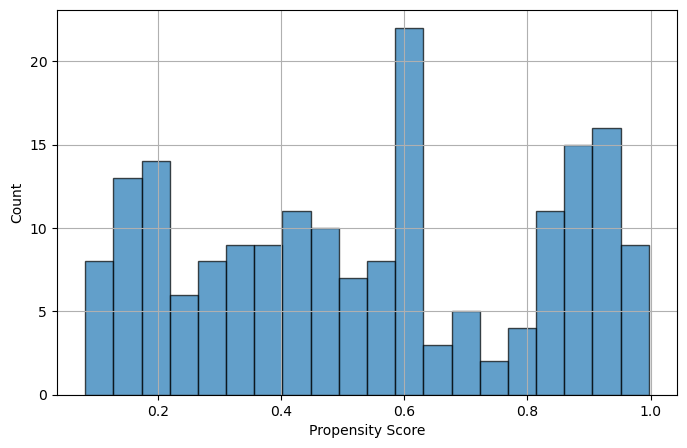

In [36]:
plt.figure(figsize=(8, 5))
plt.hist(b_df['ps'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [978]:
def ps_trim(ps, t):
    return np.clip(ps, t, 1 - t)

def lhs(gam, ps):
    return gam * np.sum((1 / (ps * (1 - ps))) <= gam)

def rhs(gam, ps):
    mask = (1 / (ps * (1 - ps))) <= gam
    return 2 * np.sum((1 / (ps * (1 - ps)))[mask])

# Find the optimal value of alpha (t)
alpha_range = np.arange(0.01, 0.5, 0.001)
gamma_vals = 1 / (alpha_range * (1 - alpha_range))
diffs = [rhs(g, ps_est) - lhs(g, ps_est) for g in gamma_vals]

# Find the minimum value of alpha where the difference >= 0
valid_idx = np.where(np.array(diffs) >= 0)[0]
gam_star = gamma_vals[valid_idx[0]]
alp_star = 0.5 - np.sqrt(0.25 - 1 / gam_star)
print(f"Optimal t according to Crump: {alp_star:.3f}")


Optimal t according to Crump: 0.100


In [979]:
# Cut on Crump threshold 
t_crump = alp_star

b_df_trimmed = b_df[(b_df['ps'] >= t_crump) & (b_df['ps'] <= 1 - t_crump)].copy()
print(f"Observations remained after trimming: {len(b_df_trimmed)} from {len(b_df)}")


Observations remained after trimming: 161 from 190


In [980]:
Y_data = b_df_trimmed['waste_per_cap'].values
D_data = b_df_trimmed['Group'].values
Z_data = b_df_trimmed.drop(columns=[
    'Country', 'Year', 'waste_per_cap', 'Policy', 'Group', 'ps'
]).values
ps_est_0 = b_df_trimmed['ps'].values

In [981]:
import scipy.io as sio
import numpy as np

output_dir = this_dir / "Replication" / "Data"

file_path = output_dir / "Real_ps_est.mat"

data_to_save = {
    "Y": Y_data.reshape(-1, 1),
    "D": D_data.reshape(-1, 1),
    "Z": Z_data,
    "ps_est": ps_est_0.reshape(-1, 1),
    "ps_coef": ps_coef_with_intercept,
}

sio.savemat(file_path, data_to_save)


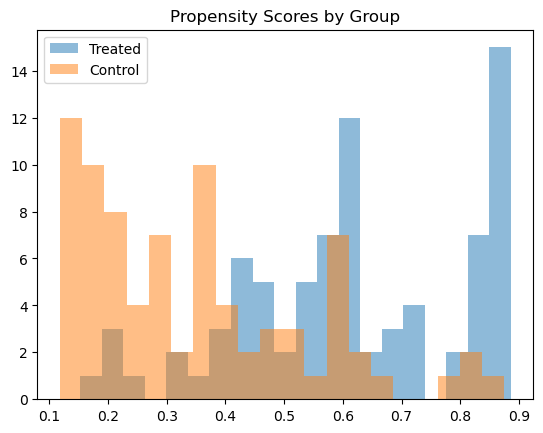

In [982]:
plt.hist(ps_est_0[D_data == 1], bins=20, alpha=0.5, label='Treated')
plt.hist(ps_est_0[D_data == 0], bins=20, alpha=0.5, label='Control')
plt.legend()
plt.title("Propensity Scores by Group")
plt.show()

In [983]:
print("Y treated avg:", Y_data[D_data == 1].mean())
print("Y control avg:", Y_data[D_data == 0].mean())

Y treated avg: 526.1851851851852
Y control avg: 437.7125


In [ ]:
# Model for Group 0
y0 = b_df_trimmed['waste_per_cap'][b_df_trimmed.Group == 0]
X0 = b_df_trimmed[["unemp_rate", 'env_tax', 'rexp_per_cap', 'urb_ind']][b_df_trimmed.Group == 0]
X0 = sm.add_constant(X0)
ols_model_0 = sm.OLS(y0, X0).fit()

# Model for Group 1
y1 = b_df_trimmed['waste_per_cap'][b_df_trimmed.Group == 1]
X1 = b_df_trimmed[["unemp_rate", 'env_tax', 'rexp_per_cap', 'urb_ind']][b_df_trimmed.Group == 1]
X1 = sm.add_constant(X1)
ols_model_1 = sm.OLS(y1, X1).fit()

# Predict potential outcomes for ALL observations
X_all = b_df_trimmed[["unemp_rate", 'env_tax', 'rexp_per_cap', 'urb_ind']]
X_all = sm.add_constant(X_all)

# Outcome if everyone was in Group 1
y_pred_1 = ols_model_1.predict(X_all)

# Outcome if everyone was in Group 0
y_pred_0 = ols_model_0.predict(X_all)

# Individual Treatment Effect (ITE)
ite = y_pred_1 - y_pred_0

# Average Treatment Effect (ATE)
ate_or_tr = np.mean(ite)

print(f"The ATE calculated using the Outcome Regression (OR) method is: {ate_or_tr:.3f}")

The ATE calculated using the Outcome Regression (OR) method is: 74.961


## DML Workflow

This study examines the effect of Policy adoption on waste level based on a country's classification into one of the two groups. Therefore, the treatment variable is binary. Country specifics, such as policies, social, and economic conditions, vary across nations; these variations are likely to cause heterogeneity of the treatment effect. Therefore,  the most suitable DML model for this analysis is IRM (Binary Interactive Regression Model).

$$
\begin{aligned}
Y &= g_0(D, X) + U, & &\mathbb{E}(U | X, D) = 0, \\
D &= m_0(X) + V, & &\mathbb{E}(V | X) = 0.
\end{aligned}
$$

As DML calculate propensity score by its own, the initial scaled df named "ml_df" will be used.

In [986]:
from help_func import find_optimal_learners
from help_func import find_optimal_lasso
from help_func import find_optimal_xgboost

In [987]:
warnings.filterwarnings('ignore', category=UserWarning, message='Propensity predictions from learner')

In [988]:
obj_dml_data = dml.DoubleMLData(ml_df, 'waste_per_cap', 'Group', x_cols=['env_tax', 'rexp_per_cap', 'urb_ind', "unemp_rate"])

# Find optimal learners
X_g = obj_dml_data.x
y_g = obj_dml_data.y
X_m = obj_dml_data.x
y_m = obj_dml_data.d

optimal_ml_g = find_optimal_learners(X_g, y_g, is_classifier=False)
optimal_ml_m = find_optimal_learners(X_m, y_m, is_classifier=True)

dml_obj = dml.DoubleMLIRM(obj_dml_data, optimal_ml_g, optimal_ml_m, n_folds=5, n_rep=5)
print(dml_obj.fit())

Fitting 5 folds for each of 45 candidates, totalling 225 fits

--- Optimal Parameters for Regressor ---
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}
Fitting 5 folds for each of 45 candidates, totalling 225 fits

--- Optimal Parameters for Classifier ---
Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: waste_per_cap
Treatment variable(s): ['Group']
Covariates: ['env_tax', 'rexp_per_cap', 'urb_ind', 'unemp_rate']
Instrument variable(s): None
No. Observations: 190

------------------ Score & algorithm ------------------
Score function: ATE

------------------ Machine learner   ------------------
Learner ml_g: RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)
Learner ml_m: RandomForestClassifier(max_depth=5, random_state=42)
Out-of-sample Performance:
Regression:
Learner ml_g0 

In [989]:
dml_ate_rf = dml_obj.summary.loc['Group', 'coef']
dml_std_rf = dml_obj.summary.loc['Group', 'std err']

In [ ]:
optimal_lasso_g = find_optimal_lasso(X_g, y_g, is_classifier=False)
optimal_lasso_m = find_optimal_lasso(X_m, y_m, is_classifier=True)

dml_irm_lasso = dml.DoubleMLIRM(obj_dml_data, optimal_lasso_g, optimal_lasso_m, n_folds=5, n_rep=5)
print(dml_irm_lasso.fit())

Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Optimal Parameters for Lasso Regressor ---
Best parameters: {'alpha': 1.0}
Fitting 5 folds for each of 100 candidates, totalling 500 fits

--- Optimal Parameters for Lasso Classifier ---
Best parameters: {'C': 1.0, 'penalty': 'l1'}
================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: waste_per_cap
Treatment variable(s): ['Group']
Covariates: ['env_tax', 'rexp_per_cap', 'urb_ind', 'unemp_rate']
Instrument variable(s): None
No. Observations: 190

------------------ Score & algorithm ------------------
Score function: ATE

------------------ Machine learner   ------------------
Learner ml_g: Lasso(random_state=42)
Learner ml_m: LogisticRegression(penalty='l1', random_state=42, solver='liblinear')
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[64.10031316]
 [63.24213844]
 [62.65858826]
 [62.18051263]
 [62.56987136]]
Learner ml_g1 R

In [991]:
dml_ate_lasso = dml_irm_lasso.summary.loc['Group', 'coef']
dml_std_lasso = dml_irm_lasso.summary.loc['Group', 'std err']

In [992]:
optimal_xgboost_g = find_optimal_xgboost(X_g, y_g, is_classifier=False)
optimal_xgboost_m = find_optimal_xgboost(X_m, y_m, is_classifier=True)

dml_irm_boost = dml.DoubleMLIRM(obj_dml_data,
                                 ml_g = optimal_xgboost_g,
                                 ml_m = optimal_xgboost_m,
                                 n_folds = 5,
                                 n_rep = 5)
dml_irm_boost.fit(store_predictions=True)
boost_summary = dml_irm_boost.summary
print(boost_summary)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits

--- Optimal Parameters for XGBoost Regressor ---
Best parameters: {'learning_rate': 0.07333333333333333, 'max_depth': 5, 'n_estimators': 200}
Fitting 5 folds for each of 200 candidates, totalling 1000 fits

--- Optimal Parameters for XGBoost Classifier ---
Best parameters: {'learning_rate': 0.1366666666666667, 'max_depth': 3, 'n_estimators': 35}
            coef    std err        t     P>|t|      2.5 %      97.5 %
Group  65.871321  23.730486  2.77581  0.005506  19.057523  112.685119


In [993]:
dml_ate_xgb = dml_irm_boost.summary.loc['Group', 'coef']
dml_std_xgb = dml_irm_boost.summary.loc['Group', 'std err']

In [994]:
import pickle
import os

# Dictionary
dml_results = {
    'rf': {
        'ate': dml_ate_rf,
        'std': dml_std_rf
    },
    'lasso': {
        'ate': dml_ate_lasso,
        'std': dml_std_lasso
    },
    'xgb': {
        'ate': dml_ate_xgb,
        'std': dml_std_xgb,
    },  
    'or': {
        'ate': ate_or,
        'ate_tr': ate_or_tr,
    }
}

file_path = os.path.join(obtained_data_dir, 'dml_results.pkl')

with open(file_path, 'wb') as f:
    pickle.dump(dml_results, f)

print(f"All DML results saved: {file_path}")

All DML results saved: data\obtained_data\dml_results.pkl
